In [7]:
import ee
import geemap

#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()

In [8]:
lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
    .filter(ee.Filter.eq('GNIS_Name', 'Big Moose Lake'))

In [9]:
station = ee.Geometry.Point(-74.85423940003443,43.81880036802749)

In [10]:
Map.addLayer(station)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [11]:
Map.centerObject(lake, 16)

In [12]:
def cdom(img):
    co = img.expression("(20.3 - 10. * (b2 / b3) - 2.4 * (b3 / b4))", {
        'b1': img.select('SR_B2'),
        'b2': img.select('SR_B3'),
        'b3': img.select('SR_B4'),
        'b4': img.select('SR_B5')
    }).rename("CO")
    return img.addBands([co])

In [13]:
collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(6, 11, 'month')) \
    .filterBounds(lake) \
    .map(cdom)


In [14]:
def get_cdom_value1(img):
    value = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=lake, scale=30).get('CO')
    return img.set('CDOM', value)

# Map over the Image Collection to get CDOM values
cdom_collection1 = collection.map(get_cdom_value1)


In [15]:
cdom_values1 = cdom_collection1.aggregate_array('CDOM').getInfo()

In [16]:
def get_cdom_value(img):
    value = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=station, scale=30).get('CO')
    return img.set('CDOM', value)

# Map over the Image Collection to get CDOM values
cdom_collection = collection.map(get_cdom_value)

In [17]:
cdom_values = cdom_collection.aggregate_array('CDOM').getInfo()
#print(cdom_values)


In [18]:
dates = cdom_collection.aggregate_array('system:time_start').getInfo()

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

# Convert the dates to datetime objects
dates = [datetime.datetime.fromtimestamp(d/1000) for d in dates]

#print(dates)


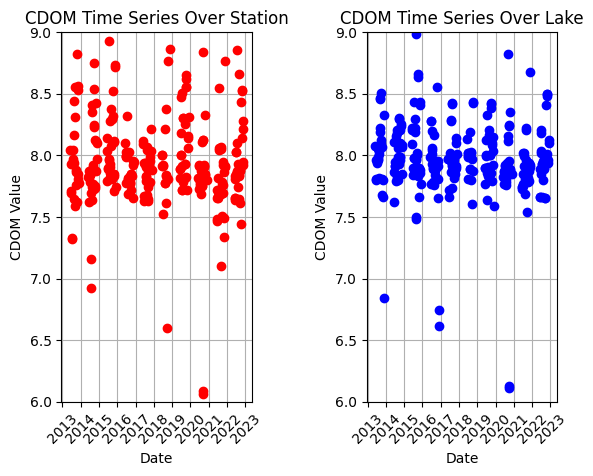

In [23]:
# Plot the time series
#Cdom value is station
plt.subplot(121)
#plt.figure(figsize=(10, 6))
plt.plot_date(dates, cdom_values, 'ro')
plt.xlabel('Date')
plt.ylabel('CDOM Value')
plt.title('CDOM Time Series Over Station')
plt.grid(True)
plt.ylim(6, 9)
plt.xticks(rotation=45)

plt.subplot(122)
plt.grid(True)
#cdom value 1 is lake
plt.plot_date(dates, cdom_values1, 'bo')
#plt.plot_date(dates, cdom_values, 'b-', marker='o')
plt.xlabel('Date')
plt.ylabel('CDOM Value')
plt.ylim(6, 9)
plt.title('CDOM Time Series Over Lake')
plt.xticks(rotation=45)
plt.grid(True)
plt.subplots_adjust(wspace=0.6)
plt.show()